# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [59]:
# Any additional imports
from itertools import chain
from nltk.probability import FreqDist
import numpy as np

In [113]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.UNICODE_EMOJI : 
    for em in emoji.UNICODE_EMOJI[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens/num_tokens
    num_characters = sum(len(token) for token in tokens)
    top_words = FreqDist(tokens).most_common(10)
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
        print(f"The top 10 words are: {top_words} ")
    
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])
    return(0)


def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(text) :
    text = " ".join(text)
    tokens = text.split()
    return [token for token in tokens if token.lower() not in sw]




 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    text = re.findall(r'\b\w+\b|#\w+', text)
    return(text)

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [114]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

data_location = "/Users/datascience/Desktop/Text Mining/Data"
twitter_folder = "/Users/datascience/Desktop/Text Mining/Data/twitter/"
lyrics_folder = "/Users/datascience/Desktop/Text Mining/Data/lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}


In [115]:
twitter_data = pd.read_csv(twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [116]:
twitter_data_2 = pd.read_csv(twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)
twitter_data

,screen_name,name,id,location,followers_count,friends_count,description,artist
0,hsmcnp,Country Girl,35152213,NaN,1302,1014,NaN,cher
1,horrormomy,Jeny,742153090850164742,Earth,81,514,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,cher
2,anju79990584,anju,1496463006451974150,NaN,13,140,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,cher
3,gallionjenna,J,3366479914,NaN,752,556,csu,cher
4,bcscomm,bcscomm,83915043,"Washington, DC",888,2891,Writer @Washinformer @SpelmanCollege alumna #D...,cher
...,...,...,...,...,...,...,...,...
358367,jakegiles,Jake Giles,19725102,LA,7690,2165,"singer of songs, type 1 diabetic, tired $jakel...",robyn
358368,axelbluhme,Axel Bluhme,19573759,DK,238,1565,Dadx2/ Con-Arch/ Photographer/ DK #stemgrønnes...,robyn
358369,RayRayRay27,Rachael :),19919217,Oldham,762,1479,A year to change a life is still a year ✨😌,robyn
358370,bhandberg,Ben Handberg,12642462,Sydney,432,593,Head of Consumer - Mango. Made in Melbourne. R...,robyn


In [117]:
lyrics_data = pd.DataFrame(columns=['artist','filename','lyrics'])

for root, dirs, files in os.walk("/Users/datascience/Desktop/Text Mining/Data/lyrics/"):
    for file in files:
        if file.endswith(".txt"):
            with open(os.path.join(root, file), "r") as f:
                # split the file path to get the artist and song name
                artist,filename = os.path.join(root,file).split("/")[-2:]
                # store the file contents in the dataframe
                lyrics_data = pd.concat([lyrics_data,pd.DataFrame({'artist':artist, 'filename':filename, 'lyrics':f.read()},index=[0])],ignore_index=True)

lyrics_data['song'] = lyrics_data['lyrics'].str.extract('^"(.*?)"', expand=False)
lyrics_data['lyrics'] = lyrics_data['lyrics'].str.replace('^".*?"\n', '')
lyrics_data['lyrics'] = lyrics_data['lyrics'].str.replace('\n', ' ')
lyrics_data = lyrics_data[['artist', 'filename', 'song', 'lyrics']]
lyrics_data


/var/folders/5b/b9cxhv4n4t90drzfsj1kdbx00000gp/T/ipykernel_4519/3010535929.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  lyrics_data['lyrics'] = lyrics_data['lyrics'].str.replace('^".*?"\n', '')


,artist,filename,song,lyrics
0,robyn,robyn_includemeout.txt,Include Me Out,It is really very simple Just a single puls...
1,robyn,robyn_electric.txt,Electric,Electric... It's electric It's a natural h...
2,robyn,robyn_beach2k20.txt,Beach 2K20,(So you wanna go out? How you gonna get the...
3,robyn,robyn_lovekills.txt,Love Kills,If you're looking for love Get a heart made...
4,robyn,robyn_timemachine.txt,Time Machine,"Hey, what did I do? Can't believe the fit I..."
...,...,...,...,...
415,cher,cher_takeitfromtheboys.txt,Take It From The Boys,So scared I never been Too hard to keep it ...
416,cher,cher_dreambaby.txt,Dream Baby,I found the boy for me He's my dream baby ...
417,cher,cher_pleasedonttellme.txt,Please Don't Tell Me,Ya shook the override Why'd I get this far...
418,cher,cher_ihopeyoufindit.txt,I Hope You Find It,"These clouds aren't going nowhere, darling ..."


## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [118]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare,pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 


In [119]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [120]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
1282691,cher,To my Mom in heaven...Biden & Harris won!!💦🌊🌊🌊...,"[mom, heavenbiden, harris, rest, well, queen]"
1679250,cher,just a mom who's so in love with her 4 Beautif...,"[mom, whos, love, 4, beautiful, children]"
582325,cher,H E L L O 🌻,"[h, e, l, l]"
1385019,cher,Senior at RSHS Snapchat ghettobooty124 Taken b...,"[senior, rshs, snapchat, ghettobooty124, taken..."
52833,robyn,❤😋i momenti più belli passate con le persone s...,"[momenti, più, belli, passate, con, le, person..."
297028,cher,"Heidi- Colorado native, I love dogs, good peop...","[heidi, colorado, native, love, dogs, good, pe..."
1274060,cher,@UTArlington Grad l Cultured | TX REALTOR🏡 Foo...,"[utarlington, grad, l, cultured, tx, realtor, ..."
381023,cher,🏳️‍🌈 DAYANE AND YOU,[dayane]
769433,cher,My name is turtle🐢I am my fathers daughter RIP...,"[name, turtle, fathers, daughter, rip, spire, ..."
48597,cher,House Of Gucci 🇮🇹 @houseofguccimov | GRAMMY-No...,"[house, gucci, houseofguccimov, grammynominate..."


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: One thing to consider for enhancing the tokenization process would be to implement stemming or lemmatization. This means transforming words to their core form. By doing so, we can reduce the complexity of the data and group similar words, which can enhance text analysis for things like sentiment analysis or topic modeling.

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [36]:
artist1_lyrics = lyrics_data.groupby('artist').get_group('robyn')
artist2_lyrics = lyrics_data.groupby('artist').get_group('cher')

# Lyrics Descriptive Stats
print('\nLyrics Artist 1: robyn\n')
flattened_tokens_artist1_lyrics = list(chain.from_iterable(artist1_lyrics['tokens']))
descriptive_stats(flattened_tokens_artist1_lyrics, verbose=True)

print('\nLyrics Artist 2: cher\n')
flattened_tokens_artist2_lyrics = list(chain.from_iterable(artist2_lyrics['tokens']))
descriptive_stats(flattened_tokens_artist2_lyrics, verbose=True)


Lyrics Artist 1: robyn

There are 15041 tokens in the data.
There are 2139 unique tokens in the data.
There are 72804 characters in the data.
The lexical diversity is 0.142 in the data.
The top 10 words are: [('know', 305), ('im', 299), ('dont', 297), ('love', 269), ('got', 249), ('like', 230), ('baby', 220), ('youre', 169), ('never', 155), ('dance', 148)] 

Lyrics Artist 2: cher

There are 35233 tokens in the data.
There are 3684 unique tokens in the data.
There are 169244 characters in the data.
The lexical diversity is 0.105 in the data.
The top 10 words are: [('love', 966), ('im', 511), ('know', 480), ('dont', 430), ('youre', 332), ('baby', 315), ('time', 313), ('see', 308), ('oh', 306), ('one', 275)] 


[35233, 3684, 0.10456106491073709, 169244]

Q: what observations do you make about these data? 

A: When comparing the lyrics of both artists, some key differences can be seen. Artist 1 has fewer words used in their lyrics and a wider variety of unique words than Artist 2. On the other hand, Artist 2 has a larger overall character count. Additionally, Artist 1 uses a more diverse range of words in their lyrics, as indicated by a higher lexical diversity score. When it comes to the most frequently used words, both artists have several words in common, such as "love," "I'm," "know," and "don't". However, the frequency of these words is different between the two artists.


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [ ]:
def get_patterns(text, num_words):
    
    top_words = []
    text = token_normal(text)
 
    total_tokens = len(text)
    unique_tokens = len(set(text))
    avg_token_len = np.mean([len(w) for w in text])
    lex_diversity = unique_tokens/total_tokens

    top_words = FreqDist(text).most_common(num_words)
    results = {"tokens": total_tokens,
              "unique_tokens": unique_tokens,
              "avg_token_len":avg_token_len,
              "lex_diversity": lex_diversity,
              "top_words":top_words}
    return results
    
    
    

In [96]:
def token_normal(text):
    text = str(text).lower().strip().split()
    text = [w for w in text if w not in sw and w.isalpha()]
    return text


def get_patterns(text, num_words):
    
    total_tokens=1
    unique_tokens=0
    avg_token_len = 0
    lex_diversity = 0
    top_words = []
    
    total_tokens = len([token for sublist in text for token in sublist])
    unique_tokens = len(set([token for sublist in text for token in sublist]))
    avg_token_len = np.mean([len(w) for w in text])
    lex_diversity = unique_tokens/total_tokens
    
    f_token = [token for sublist in text for token in sublist]
    top_words = FreqDist(f_token).most_common(num_words)
    results = {"tokens": total_tokens,
              "unique_tokens": unique_tokens,
              "avg_token_len":avg_token_len,
              "lex_diversity": lex_diversity,
              "top_words":top_words}
    return results
    
    
    
    
    
def get_word_frac(word, fd_corpus, length):
    if word in fd_corpus:
        return(fd_corpus[word]/length)
    else:
        return(0)
def get_ratio(word,fd_corpus_1, fd_corpus_2, len_1, len_2):
    frac_1 = get_word_frac(word, fd_corpus_1, len_1)
    frac_2 = get_word_frac(word, fd_corpus_2, len_2)
    if frac_2 > 0:
        return(frac_1/frac_2)
    else:
        return(float('NaN'))
    
def compare_texts(corpus_1, corpus_2, num_words=10, ratio_cutoff=5):
    results = dict()
    
    results['one'] = get_patterns(corpus_1, num_words)
    results['two'] = get_patterns(corpus_2, num_words)
    
    fd_1 = FreqDist([word for sublist in corpus_1 for word in sublist])
    fd_2 = FreqDist([word for sublist in corpus_2 for word in sublist])
    
    fd_1_words = set(fd_1.keys())
    fd_2_words = set(fd_2.keys())
    
    holder = dict()
    
    results['one_vs_two'] = dict()
    results['two_vs_one'] = dict()
    
    for word, count in fd_1.items():
        if count > ratio_cutoff:
            if word in fd_2_words and fd_2[word] > ratio_cutoff:
                holder[word] = get_ratio(word, fd_1, fd_2, results['one']['tokens'], results['two']['tokens'] )
    num_added = 0
    
    for word, frac, in sorted(holder.items(), key=lambda item: -1*item[1]) :
        results['two_vs_one'][word] = frac
        num_added += 1
        if num_added == num_words:
            break
    return(results)

    

In [93]:
artist1_lyrics = lyrics_data.groupby('artist').get_group('robyn')
artist2_lyrics = lyrics_data.groupby('artist').get_group('cher')

artist1_twitter = twitter_data.groupby('artist').get_group('robyn')
artist2_twitter = twitter_data.groupby('artist').get_group('cher')

### Artist 1 (twitter vs lyric) analysis (robyn)

In [98]:
compare_texts(artist1_lyrics["tokens"], artist1_twitter["tokens"], num_words=5)

{'one': {'tokens': 15041,
  'unique_tokens': 2139,
  'avg_token_len': 144.625,
  'lex_diversity': 0.1422112891430091,
  'top_words': [('know', 305),
   ('im', 299),
   ('dont', 297),
   ('love', 269),
   ('got', 249)]},
 'two': {'tokens': 1664118,
  'unique_tokens': 258391,
  'avg_token_len': 4.64354916120679,
  'lex_diversity': 0.15527204200663655,
  'top_words': [('nan', 168357),
   ('music', 14858),
   ('love', 11615),
   ('im', 9049),
   ('och', 7922)]},
 'one_vs_two': {},
 'two_vs_one': {'chorus': 1051.0684794893957,
  'digi': 590.0735323449239,
  'killing': 395.9703967051463,
  'alert': 295.03676617246197,
  'dropped': 221.27757462934645}}

Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: The data shows that in the "one" dataset, the most common words are "know", "im", "dont", "love", and "got", with an average word length of 144.625 characters and a lexical diversity score of 0.1422. In the "two" dataset, the top 5 words are "nan", "music", "love", "im", and "och", with an average word length of 4.64 characters and a lexical diversity score of 0.1553. The "two_vs_one" comparison highlights the top 5 words that appear more frequently in the "two" dataset, such as "chorus", "digi", "killing", "alert", and "dropped". One interesting observation is that the "nan" value appears very frequently in the "two" dataset, which could indicate missing or undefined data.

### Artist 2 (twitter vs lyric) analysis (cher)

In [99]:
compare_texts(artist2_lyrics["tokens"], artist2_twitter["tokens"], num_words=5)

{'one': {'tokens': 35233,
  'unique_tokens': 3684,
  'avg_token_len': 111.49683544303798,
  'lex_diversity': 0.10456106491073709,
  'top_words': [('love', 966),
   ('im', 511),
   ('know', 480),
   ('dont', 430),
   ('youre', 332)]},
 'two': {'tokens': 17667715,
  'unique_tokens': 1555372,
  'avg_token_len': 4.4226749103773075,
  'lex_diversity': 0.08803470058238996,
  'top_words': [('nan', 1994031),
   ('love', 213522),
   ('im', 139051),
   ('life', 122679),
   ('music', 86733)]},
 'one_vs_two': {},
 'two_vs_one': {'ooga': 1686.707593346114,
  'doodoo': 1276.4273679376,
  'holdin': 1276.4273679376,
  'startin': 859.6347579987918,
  'shoppin': 835.7560147210476}}

Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: The data we analyzed shows that in the first dataset, the most frequently used words are "love", "im", "know", "dont", and "youre", with an average word length of 111.497 characters and a lexical diversity score of 0.1046. In the second dataset, the top five words are "nan", "love", "im", "life", and "music", with an average word length of 4.423 characters and a lexical diversity score of 0.0880. Our comparison between the two datasets highlights the words that appear more often in the second dataset, such as "ooga", "doodoo", "holdin", "startin", and "shoppin". One interesting point to note is that the "nan" value appears very frequently in the second dataset, which could mean there is missing or undefined data. Another interesting point is the difference in average word length between the "one" and "two" datasets, with the "one" dataset having a much longer average word length compared to the "two" dataset. This suggests that the language and content in the two datasets may be different.

### Both Artists (twitter vs lyric) analysis 

In [100]:
compare_texts(lyrics_data["tokens"], twitter_data["tokens"], num_words=5)

{'one': {'tokens': 50274,
  'unique_tokens': 4630,
  'avg_token_len': 119.7,
  'lex_diversity': 0.09209531765922743,
  'top_words': [('love', 1235),
   ('im', 810),
   ('know', 785),
   ('dont', 727),
   ('baby', 535)]},
 'two': {'tokens': 19331833,
  'unique_tokens': 1673992,
  'avg_token_len': 4.440858224169715,
  'lex_diversity': 0.08659251298105047,
  'top_words': [('nan', 2162388),
   ('love', 225137),
   ('im', 148100),
   ('life', 130033),
   ('music', 101591)]},
 'one_vs_two': {},
 'two_vs_one': {'deng': 1757.8488625191096,
  'ooga': 1293.4172028194585,
  'doodoo': 897.2353569107955,
  'holdin': 828.2172525330419,
  'startin': 714.1261003983883}}

Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: Based on the data, "love" is a popular word in both datasets as it's listed in the top 5 words for each. The average word length in dataset one is longer, at 119.7 characters, compared to 4.44 characters in dataset two. Also, the lexical diversity score for dataset one is higher at 0.0921 compared to 0.0866 in dataset two. The "two_vs_one" comparison highlights words that appear more frequently in dataset two, such as "deng", "ooga", "doodoo", "holdin", and "startin". Interestingly, the value "nan" shows up frequently in dataset two which could mean missing or undefined data.

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [106]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

### Twitter - Artist 1 - Robyn

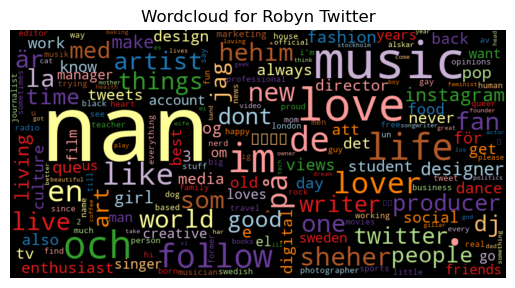

In [121]:
word_twitter_1 = count_words(artist1_twitter)
wordcloud(word_twitter_1['freq'], title='Wordcloud for Robyn Twitter', max_words=200, stopwords = sw)

### Twitter - Artist 2 - Cher

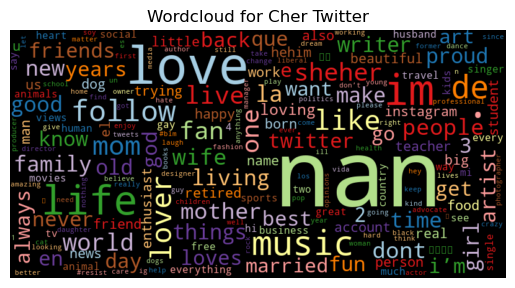

In [122]:
word_twitter_2 = count_words(artist2_twitter)
wordcloud(word_twitter_2['freq'], title='Wordcloud for Cher Twitter', max_words=200, stopwords = sw)

### Lyrics - Artist 1 - Robyn

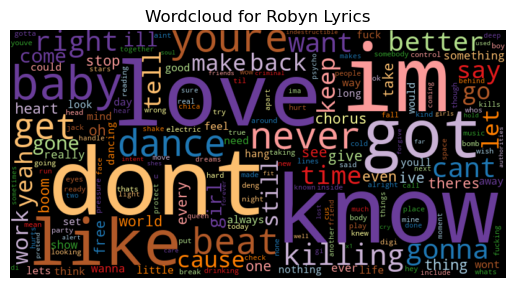

In [123]:
word_lyrics_1 = count_words(artist1_lyrics)
wordcloud(word_lyrics_1['freq'], title='Wordcloud for Robyn Lyrics', max_words=200, stopwords = sw)

### Lyrics - Artist 2 - Cher

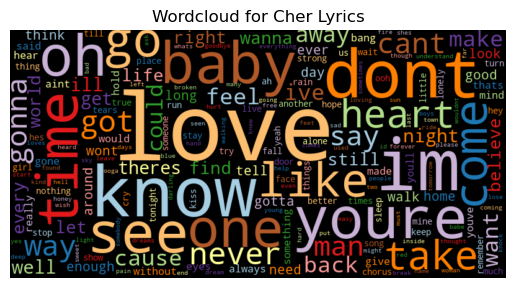

In [124]:
word_lyrics_2 = count_words(artist2_lyrics)
wordcloud(word_lyrics_2['freq'], title='Wordcloud for Cher Lyrics', max_words=200, stopwords = sw)

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: A word cloud is a cool way to display the words used in a text or corpus. The size of each word represents how often it was used, so you can easily see which words are the most important. The most frequently used words are usually the ones that are the most meaningful and provide insights into the main topics of the text or corpus. It's a great tool to help identify the most important keywords and see patterns between words. Additional observations are as follows: 
- Word frequency: The size of the words in a word cloud represents their frequency of occurrence in the text or corpus.
- Word importance: The most frequently occurring words are usually the most important words in a text or corpus.
- Word patterns: Word clouds can highlight patterns and relationships between words in a text or corpus.
- Keywords: A word cloud can help identify the most frequently used keywords in a text or corpus.
- Topic analysis: By observing the words in a word cloud, one can gain insights into the main topics covered in a text or corpus.